<a href="https://colab.research.google.com/github/PheOrlya/SSSL_pr2-OrlyanskyVE/blob/main/%D0%A1%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D0%B0_%D0%B4%D0%BB%D1%8F_%D1%81%D0%B1%D0%BE%D1%80%D0%B0_%D1%81%D0%BE%D0%B1%D1%8B%D1%82%D0%B8%D0%B9_%D0%B8_%D0%BB%D0%BE%D0%B3%D0%BE%D0%B2_%D0%9F%D0%A02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/logpai/loghub

Cloning into 'loghub'...
remote: Enumerating objects: 557, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 557 (delta 55), reused 52 (delta 47), pack-reused 474
Receiving objects: 100% (557/557), 7.32 MiB | 17.35 MiB/s, done.
Resolving deltas: 100% (255/255), done.


In [2]:
%cd /content/loghub/HDFS
!pwd

/content/loghub/HDFS
/content/loghub/HDFS


Описание структуры полей логов и разработка парсера:

1) Изучите структуру полей лог-файлов, определите, какие информационные элементы содержатся в каждом лог-сообщении.
*   Date: сопоставляет дату: 081109.
*   Time: сопоставляет время: 204005.
*   Process ID: Номер, следующий за меткой времени, который может обозначать ID процесса, исполняемого в момент записи в журнал: 35.
*   Log Level: Индикатор уровня логирования строки журнала: INFO.
*   Source: Компонент системы, генерировавший журнальную запись: dfs.FSNamesystem.
*   Message: Собственно сообщение в журнале: BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.73.220:50010 is added to blk_7128370237687728475 size 67108864.

2) Разработайте парсер для не менее чем 5 видов сообщений, чтобы выделить каждый элемент информации в отдельные поля.

За основу был взят пример парсера приведенный в работе и переделан под необходимый формат лога

In [29]:
import re

log_line = "081109 204005 35 INFO dfs.FSNamesystem: BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.73.220:50010 is added to blk_7128370237687728475 size 67108864"
regex_pattern = r'(\d{6}) (\d{6}) (\d+) (\w+) (.*?):\s+(.*)'

matches = re.match(regex_pattern, log_line)
if matches:
    date = matches.group(1)
    time = matches.group(2)
    process_id = matches.group(3)
    log_level = matches.group(4)
    source = matches.group(5)
    message = matches.group(6)

print("Date:", date)
print("Time:", time)
print("Process ID:", process_id)
print("Log Level:", log_level)
print("Source:", source)
print("Message:", message)

Date: 081109
Time: 204005
Process ID: 35
Log Level: INFO
Source: dfs.FSNamesystem
Message: BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.73.220:50010 is added to blk_7128370237687728475 size 67108864


Парсинг лога и сохранение в СУБД:

3) Распарсите лог-файл с использованием разработанного парсера.

4) Сохраните каждую запись в соответствующие таблицы вашей базы данных. (Данные сохранены в log_data)

При сохранении возникла ошибка, которая выводила все данные в один столбец черезх запятую.

Данную ошибку получилось исправить использовав ; вместо , в качестве разделителя

In [61]:
!pip install pandas

In [69]:
import re
import pandas as pd

#Создание хранилища для записи логов
log_data = []

#Открытие файла с логами и прочтение их построчно
with open('HDFS_2k.log', 'r') as file:
  for line in file:

    regex_pattern = r'(\d{6}) (\d{6}) (\d+) (\w+) (.*?):\s+(.*)'

    matches = re.match(regex_pattern, line)
    if matches:
        date = matches.group(1)
        time = matches.group(2)
        process_id = matches.group(3)
        log_level = matches.group(4)
        source = matches.group(5)
        message = matches.group(6)

        # Преобразование логов в отдельные блоки
        log_data.append({
            "Date": date,
            "Time": time,
            "Process ID": process_id,
            "Log Level": log_level,
            "Source": source,
            "Message": message
        })

#Преобразование хранилища в DataFrame
df = pd.DataFrame(log_data)

#Вывод DataFrame`a
print(df)

#Сохранение DataFrame`a в файл .csv
df.to_csv('log_data.csv', sep=';', index=False)

        Date    Time Process ID Log Level                        Source  \
0     081109  203615        148      INFO  dfs.DataNode$PacketResponder   
1     081109  203807        222      INFO  dfs.DataNode$PacketResponder   
2     081109  204005         35      INFO              dfs.FSNamesystem   
3     081109  204015        308      INFO  dfs.DataNode$PacketResponder   
4     081109  204106        329      INFO  dfs.DataNode$PacketResponder   
...      ...     ...        ...       ...                           ...   
1995  081111  101621      24902      INFO      dfs.DataNode$DataXceiver   
1996  081111  101735      26595      INFO  dfs.DataNode$PacketResponder   
1997  081111  101804      26494      INFO      dfs.DataNode$DataXceiver   
1998  081111  101954      26414      INFO  dfs.DataNode$PacketResponder   
1999  081111  102017      26347      INFO      dfs.DataNode$DataXceiver   

                                                Message  
0     PacketResponder 1 for block blk_388

Нормализация логов и сохранение в СУБД:

5) Выполните нормализацию логов (приведение к единой форме).

6) Сохраните нормализованные записи в соответствующие таблицы вашей СУБД.

In [86]:
import re
import pandas as pd
from datetime import datetime

#Создание хранилища для записи логов
log_data = []

#Открытие файла с логами и прочтение их построчно
with open('HDFS_2k.log', 'r') as file:
  for line in file:

    regex_pattern = r'(\d{6}) (\d{6}) (\d+) (\w+) (.*?):\s+(.*)'

# Удалить повторяющиеся строки
    df = df.drop_duplicates()

# Сохранить DataFrame в .csv файле
    df.to_csv('log_data_norm.csv', sep=';', index=False)

    matches = re.match(regex_pattern, line)
    if matches:
        date = matches.group(1)
        time = matches.group(2)
        process_id = matches.group(3)
        log_level = matches.group(4).upper()
        source = matches.group(5).strip()
        message = matches.group(6).strip()

        # Преобразование логов в отдельные блоки
        date_obj = datetime.strptime(date, "%y%m%d")
        time_obj = datetime.strptime(time, "%H%M%S")
        formatted_date = date_obj.strftime("%Y-%m-%d")
        formatted_time = time_obj.strftime("%H:%M:%S")

        log_data.append({
            "Date": formatted_date,
            "Time": formatted_time,
            "Process ID": process_id,
            "Log Level": log_level,
            "Source": source,
            "Message": message
        })

#Преобразование хранилища в DataFrame
df = pd.DataFrame(log_data)

#Вывод DataFrame`a
print(df)

#Сохранение DataFrame`a в файл .csv
df.to_csv('log_data_norm.csv', sep=';', index=False)

            Date      Time Process ID Log Level                        Source  \
0     2008-11-09  20:36:15        148      INFO  dfs.DataNode$PacketResponder   
1     2008-11-09  20:38:07        222      INFO  dfs.DataNode$PacketResponder   
2     2008-11-09  20:40:05         35      INFO              dfs.FSNamesystem   
3     2008-11-09  20:40:15        308      INFO  dfs.DataNode$PacketResponder   
4     2008-11-09  20:41:06        329      INFO  dfs.DataNode$PacketResponder   
...          ...       ...        ...       ...                           ...   
1995  2008-11-11  10:16:21      24902      INFO      dfs.DataNode$DataXceiver   
1996  2008-11-11  10:17:35      26595      INFO  dfs.DataNode$PacketResponder   
1997  2008-11-11  10:18:04      26494      INFO      dfs.DataNode$DataXceiver   
1998  2008-11-11  10:19:54      26414      INFO  dfs.DataNode$PacketResponder   
1999  2008-11-11  10:20:17      26347      INFO      dfs.DataNode$DataXceiver   

                           

Статистический анализ и визуализация:

7) Проведите статистический анализ данных по различным полям (например, по уровню логирования, частоте определенных событий).

8) Визуализируйте результаты с использованием библиотек Python, таких как Pandas и Matplotlib.

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv('log_data_norm.csv')

print(df.columns)


Index(['Date;Time;Process ID;Log Level;Source;Message'], dtype='object')


INFO    1920
WARN      80
Name: Log Level, dtype: int64


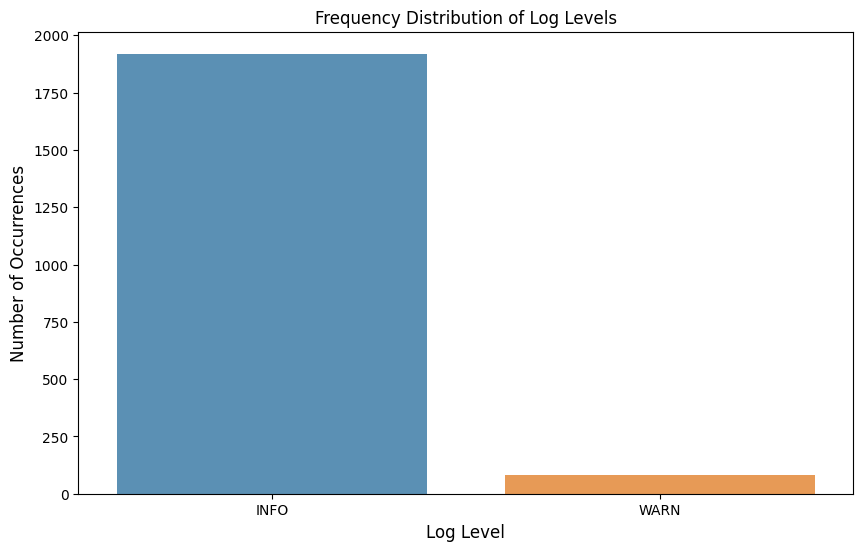

PacketResponder 1 for block blk_38865049064139660 terminating                                                                  1
BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.203.166:50010 is added to blk_-2332150303475653460 size 67108864    1
Receiving block blk_345577139488306634 src: /10.251.37.240:38873 dest: /10.251.37.240:50010                                    1
PacketResponder 2 for block blk_-3363550789841756902 terminating                                                               1
PacketResponder 1 for block blk_4178945095089206682 terminating                                                                1
Name: Message, dtype: int64


In [95]:
df = pd.read_csv('log_data_norm.csv', delimiter=';')

# Вычисление частоты разных данных в столбце "Log Level"
log_level_counts = df['Log Level'].value_counts()
print(log_level_counts)

#Визуализация разницы частот данных
plt.figure(figsize=(10,6))
sns.barplot(x=log_level_counts.index, y=log_level_counts.values, alpha=0.8)
plt.title('Frequency Distribution of Log Levels')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Log Level', fontsize=12)
plt.show()

#Частота встречающихся событий
message_counts = df['Message'].value_counts()
print(message_counts.head())